In [1]:
import sys 
import subprocess 
import pkgutil

def pip_install(pkg):
    if pkg.replace('-', '_') not in {m.name for m in pkgutil.iter_modules()}:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

for p in ['torch', 'matplotlib', 'numpy', 'transformers', 'tqdm', 'requests']:
    try:
        pip_install(p)
    except Exception as e:
        print(f'Warning: could not ensure install for {p}: {e}')

In [2]:
import math
import time
import os
import json
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
import requests
# URL for the Shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
file_path = "input.txt"

# Only download if the file doesn't exist yet
if not os.path.exists(file_path):
    print("Downloading dataset...")
    response = requests.get(url)
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(response.text)
    print("Download complete.")
else:
    print("File already exists.")

File already exists.


In [4]:
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Length of dataset in characters: {len(text)}")
print(f"First 100 characters:\n{text[:100]}")

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)

string_to_integer = {ch:i for i,ch in enumerate(chars)}
integer_to_string = {i:ch for i,ch in enumerate(chars)}
encode = lambda s: [string_to_integer[c] for c in s]
decode = lambda l: ''.join([integer_to_string[i] for i in l])

print(encode("Hello"))
print(decode(encode("Hello")))

Length of dataset in characters: 1115394
First 100 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65
[20, 43, 50, 50, 53]
Hello


For defining the limits of the hardware. Roofline model can help us compare the Performance (How fast it can calculate) against the Arithmetic Intensity (how much reuse of data).

- Peak Compute (Flops): Fastest the chip can do math.
- Peak Bandwidth (GB/s): The fastest the chip can move data. (Memory Bandwidth)

In [5]:
# Add in the Hardware SPECS
# I have an Intel core Ultra 7 265H machine with a integrated GPU (Arc 140T) single precision
Peak_Flops = 5 * 1e12  # 5 TFLOPS - How fast can it think? (T - Tera = 10^12)
Peak_Bandwidth = 100 * 1e9  # 100 GB/s - How fast can it read? (Giga = 10^9)

# If run on Google Collab T4 GPU uncomment the below
#Peak_Flops = 8 * 1e12  # 8 TFLOPS
#Peak_Bandwidth = 320 * 1e9  # 320 GB/s

The 'Roofline' is the Physical limit of the hardware and has two parts - 
- Slanted Roof (Memory Bound): Limited by how fast data arrives - Performance = Intensity * Bandwidth
- Flat Roof (Compute Bound): Hit the max speed of the math units - Performance = Peak_FLOPS

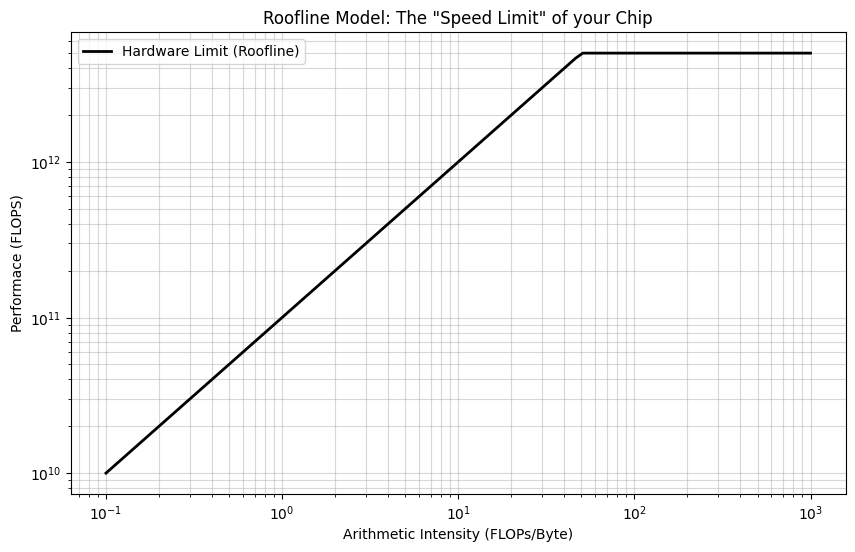

In [6]:
x = np.logspace(-1, 3, 100)  # Log scale from 0.1 to 1000 FLOPS/Byte

y_mem = x * Peak_Bandwidth  # Limit imposed by Memory Bandwidth (Slant)

y_compute = np.full_like(x, Peak_Flops)  # Limit imposed by Compute Speed (Flat ceiling)

y_roof = np.minimum(y_mem, y_compute)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y_roof, 'k-', linewidth=2, label='Hardware Limit (Roofline)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
ax.set_ylabel('Performace (FLOPS)')
ax.set_title('Roofline Model: The "Speed Limit" of your Chip')
ax.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

In [7]:
embed_size = 128
num_heads = 4
num_layers = 2
head_size = embed_size // num_heads
precision = 2  # FP16 (2 bytes per number)

# Per Attention layer
# Each head has 3 projections - Q, K, V
# Shape: (embed_size, head_size) = (128, 32) each
params_per_head_qkv = 3 * (embed_size * head_size)
params_all_heads_qkv = num_heads * params_per_head_qkv
params_proj = embed_size * embed_size

# Total attention params per layer
params_attention = params_all_heads_qkv + params_proj

# Feedforward
# embed_size -> 4*embed_size -> embed_size
params_ff = (embed_size * 4 * embed_size) + (4 * embed_size * embed_size)

# Total parameters for one transformer block
params_per_block = params_attention + params_ff

# Total for all layers
total_params = num_layers * params_per_block

A PyTorch `nn.Linear(in_features, out_features)` is just a matrix with:
- `in_features * out_features` numbers (weights)

so attention projections:
- `self.key = nn.Linear(embed_size, head_size)`
- `self.query = nn.Linear(embed_size, head_size)`
- `self.value = nn.Linear(embed_size, head_size)`

Each of the above has `embed_size * head_size` weights

So for one head:
- Q, K, V together have `3 * (embed_size * head_size)` parameters
- For all the heads its simple multiplication of num_heads -> `num_heads * 3 * (embed_size * head_size)`

After the heads are concatenated, there is:
- `self.proj = nnLinear(embed_size, embed_size)` which has `embed_size * embed_size` weights

So attention part per block:
- `params_attention = ( num_heads * 3 * (embed_size * head_size) ) + (embed_size * embed_size)`

For feedforward -

First Layer - `nn.Linear(embed_size, 4*embed_size)`
Second Layer - `nn.Linear(4*embed_size, embed_size)`

So feedforward per block:
`params_ff = (embed_size * 4 * embed_size) + (4 * embed_size * embed_size)`

Now per block is this `params_per_block = params_attention + params_ff`
in all blocks its just multiplications of `total_params = num_layers * params_per_block`

In DECODE PHASE,
for one token, each weight is used once in a matrix-vector multiply.

For each weight:
- Multiply (weight * Input) and then add it to an accumulator.
That is a 2 FLOPS per weight.
Therefore, `total_flops = 2 * total_params`

To use weights we must read it from the memory into the chip,
Each weight is stored as FP16 bytes per number.
So, `total_bytes = total_params * precision`

In [8]:
# DECODE PHASE
# FLOPs - 2 operations (Multiply + Add) per parameter
total_flops = 2 * total_params

# Bytes - Load all weights from memory
total_bytes = total_params * precision

# Arithmetic Intensity
ai_decode = total_flops / total_bytes

print(f"For every byte loaded from memory, you perform only {ai_decode:.1f} floating-point operations.")

For every byte loaded from memory, you perform only 1.0 floating-point operations.


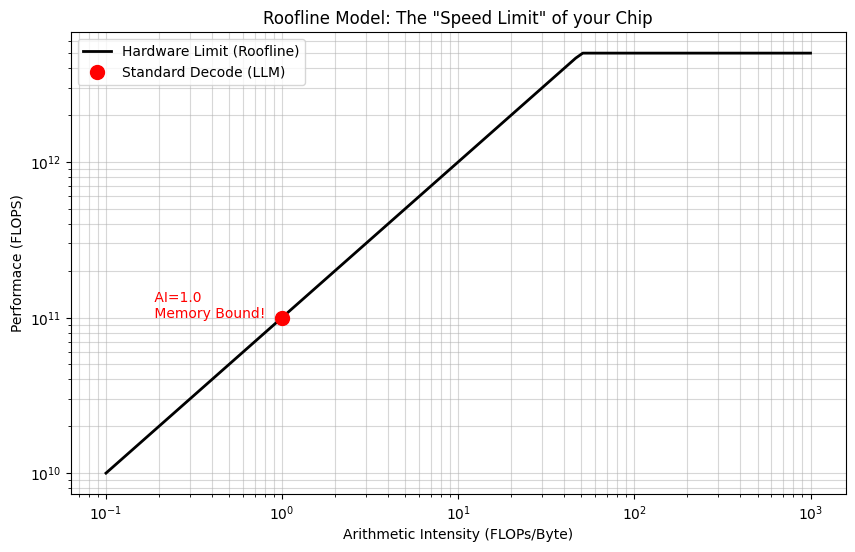

In [9]:
# Calculate where our Decode operation hits the roof
attainable_perf = min(Peak_Flops, ai_decode * Peak_Bandwidth)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y_roof, 'k-', linewidth=2, label='Hardware Limit (Roofline)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity (FLOPs/Byte)')
ax.set_ylabel('Performace (FLOPS)')
ax.set_title('Roofline Model: The "Speed Limit" of your Chip')
ax.grid(True, which="both", ls="-", alpha=0.5)
ax.plot(ai_decode, attainable_perf, 'ro', markersize = 10, label = 'Standard Decode (LLM)')
ax.text(ai_decode * 10**(-0.75), attainable_perf , f" AI={ai_decode:.1f}\n Memory Bound!", color='red')
plt.legend()
plt.show()